In [1]:
from agents import Agent, User, Module, Orchestrator
from agents.scripted_users import UserHIAAC
from capabilities.skills import WebCrawler, GoogleDocsReader
import os
import json

c:\Users\FS-Ma\OneDrive\Documents\projects\arara\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
llm_config = {
    "config_list": [
        {
            "client": "groq",
            "temperature": 0.0,
            "model": "gemma2-9b-it",
            "api_key": os.getenv("GROQ_API_KEY")
        }
    ]
}

with open(r'C:\Users\FS-Ma\OneDrive\Documents\arara-461102-af3f0fba23f1.json', 'r', encoding='utf-8') as arquivo_json:
    creds = json.load(arquivo_json)

In [3]:
user = UserHIAAC(
    name="student",
    description="The human user, a student from HIAAC, who asks questions to the system."
)

meeting_agent = Agent(
    name="meeting",
    description=(
        "Answers questions *strictly* about HIAAC meetings based on the provided meeting information text. "
        "Use this agent *only* if the user's question is about HIAAC meeting details (like dates, times, agenda items, or decisions) "
        "and the relevant meeting information is supplied in the current context."
    ),
    system_message="""
        You are a specialized assistant for answering questions about HIAAC meetings.
        You will be provided with text containing information about HIAAC meetings.
        Your sole function is to answer user questions *directly* and *exclusively* about HIAAC meetings by referencing *only* the provided meeting information text.
        Do not make assumptions or retrieve information from any external sources.
        If the question is about HIAAC meetings, analyze the provided text carefully and formulate a direct response to the user based *only* on that text.
        Do not answer questions about researchers, general topics, or casual conversation.
        If the necessary information to answer a meeting-related question is not present in the provided text, state that the information is not available in the provided context.
    """,
    skills=[
        GoogleDocsReader(
            urls=["https://docs.google.com/document/d/1pAsptw5QUqHWSx-aj47SFbHEUGDvep6q8gHhI5tVE5A/edit?usp=sharing"],
            credentials_info=creds
        )
    ],
    llm_config=llm_config,
)

website = Agent(
    name="website",
    description=(
        "Answers questions *strictly* about HIAAC researchers by fetching information from the official website. "
        "Use this agent *only* if the user's question is about HIAAC researcher information (such as research areas, publications, contact, etc.)."
    ),
    system_message="""
        You are an assistant specialized in finding information about HIAAC researchers on the official website: https://hiaac.unicamp.br/researchers/.
        Your sole function is to answer user questions *directly* and *exclusively* about HIAAC researchers.
        Use the WebCrawler skill to search for information on the specified website and, based on the results, formulate a direct response to the user.
        Do not answer questions about HIAAC meetings, general topics, or casual conversation.
        If the question is about HIAAC researchers, use the WebCrawler and respond directly to the user.
    """,
    skills=[
        WebCrawler(
            urls=["https://hiaac.unicamp.br/researchers/"]
        )
    ],
    llm_config=llm_config,
)

conversational = Agent(
    name="AraraBot",
    description=(
        "Conversational agent for general topics and casual chat. "
        "Use this agent if the user's question is *not* specifically about HIAAC meetings or HIAAC researchers."
    ),
    system_message="""
        You are a friendly chatbot designed for casual and informal conversations.
        Your role is to chat with the user about topics that are *not* specifically about HIAAC meetings or HIAAC researchers.
        Respond дружелюбно and appropriately to the tone of the conversation.
        Do not attempt to answer questions about HIAAC meetings or researchers; other agents are specialized for that.
    """,
    llm_config=llm_config,
)

speaker_transitions = {
    user:[conversational, meeting_agent, website],
    conversational:[user],
    meeting_agent:[user],
    website:[user],
}
main_module = Module(
    admin_name="main_module",
    agents=[user, conversational, meeting_agent, website],
    speaker_selection_method="auto",
    speaker_transitions_type="allowed",
    allowed_or_disallowed_speaker_transitions=speaker_transitions,
)

# Orchestrator to manage the conversation flow
arara_orc = Orchestrator(
    name="main_orchestrator",
    module=main_module,
    llm_config=llm_config,
    system_message="traduza tudo para japones",
)

In [4]:
chat_result = user.talk_to(arara_orc, message="Oi tudo bem?")

student ⟶ main_orchestrator:
Oi tudo bem?

Next speaker: AraraBot

AraraBot ⟶ main_orchestrator:
Oi! Tudo bem sim, e com você? 😊  What's going on?  


Next speaker: student

student ⟶ main_orchestrator:
Quando será a proxima reuniao?

Next speaker: meeting

meeting ⟶ main_orchestrator:
A próxima reunião será em 05/12 às 09h00.  


Next speaker: student

student ⟶ main_orchestrator:
Liste os pesquisadores do hiaac

Next speaker: website

website ⟶ main_orchestrator:
Aqui está uma lista dos pesquisadores do HIAAC, baseada na informação disponível no site:

**Aprendizado Distribuído**
* Leandro Villas
* Allan M. de Souza
* Luiz Bittencourt
* Eduardo Cerqueira
* Antonio A. F. Loureiro
* Joahannes B. D. da Costa
* Daniel L. Guidoni
* Denis Lima do Rosário
* Felipe Domingos da Cunha
* Lucas de Lima Bastos
* Maycon Leone Maciel Peixoto
* Augusto José Venâncio Neto
* Luis F. G. Gonzalez

**Aprendizado em Arquiteturas Cognitivas**
* Esther Colombini
* Alexandre Simões
* Marcos O. Máximo
* Cinar

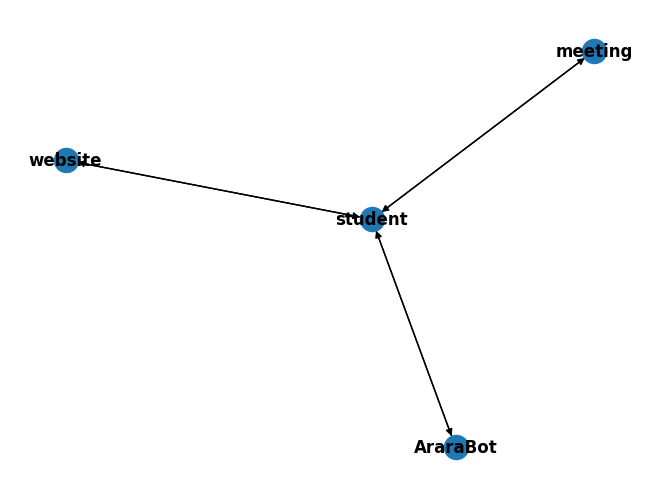

In [5]:
from agents.helpers.graph_utils import visualize_speaker_transitions_dict
visualize_speaker_transitions_dict(speaker_transitions, [user, conversational, meeting_agent, website])